<IPython.core.display.Javascript object>


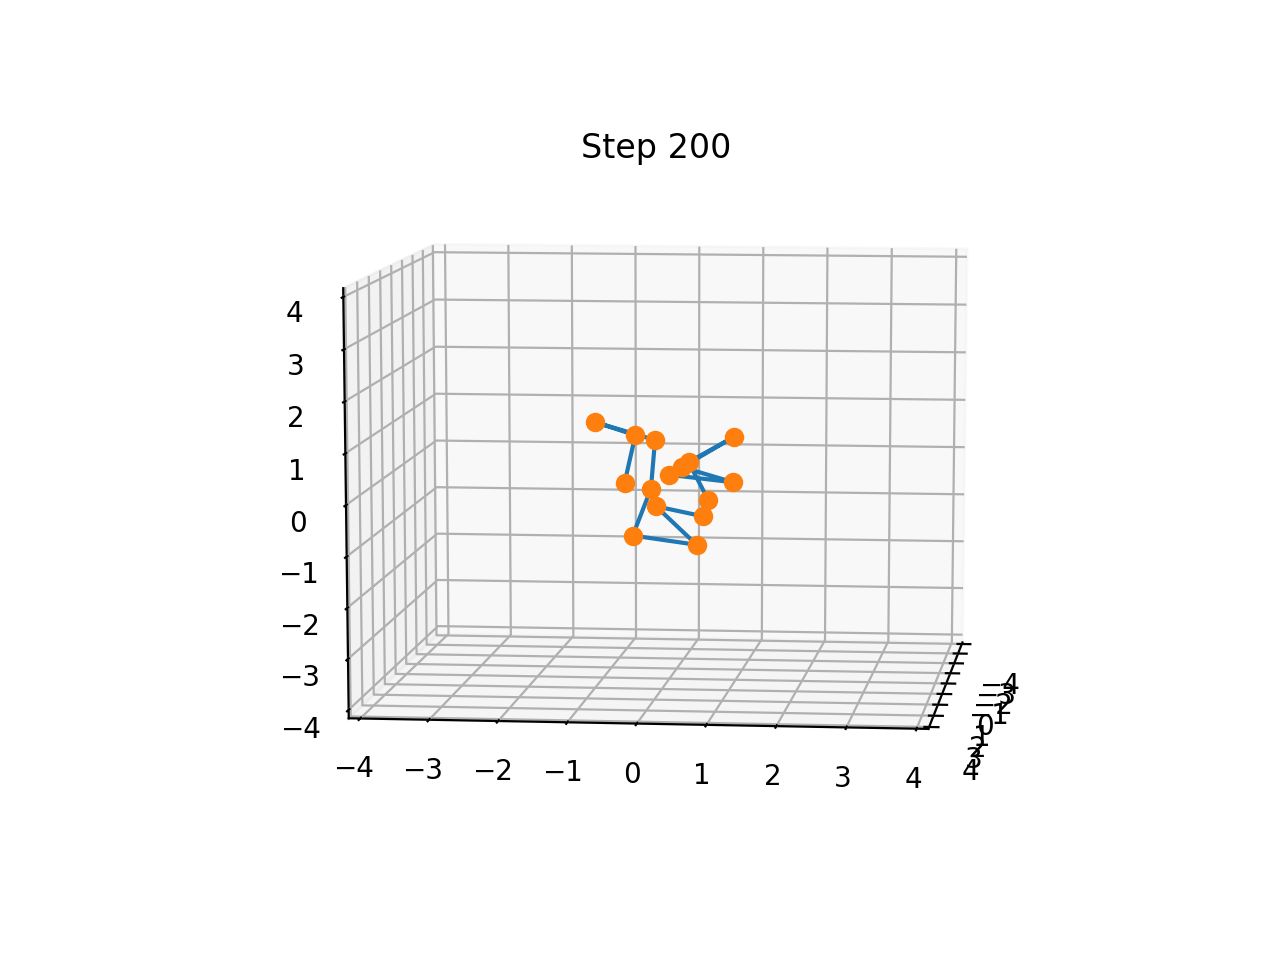

<IPython.core.display.Javascript object>


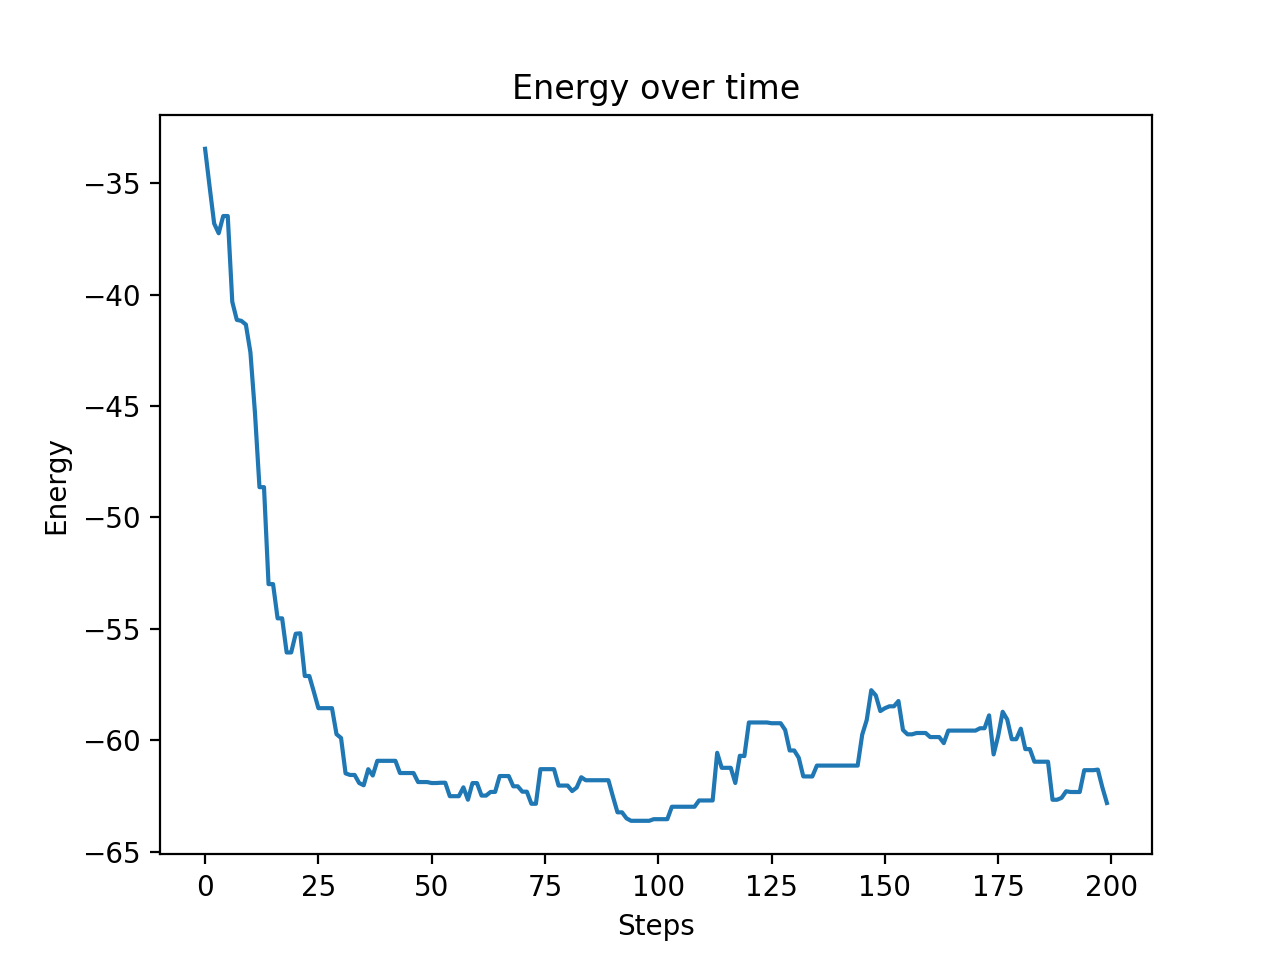

In [4]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Protein Folding Monte Carlo by Bhareth Kachroo
# Using as simple a model as possible to reproduce a funneled energy landscape.
# 20 Amino acid type as points, with randomized interaction energies and characteristic length
# scales, where energy is calculated with a Lennard-Jones type exponential potential.
# Vary absolute angle instead of acid positions randomly, leads to much faster convergence,
# as bond length energy outweighs any other interactions.

# CONSTANTS
N = 15 # the length of the chain
num_amino_acids = 20 # types of amino acid
R = 1 # constant distance between acids
T = 1 # temperature for Boltzmann factor
potential_radius = 0.2 # units of bond length
steps = 200

# GEOMETRY functions: ----------

# output: absolute positions of each acid based on spherical 
# angles between each acid in the chain, using spherical
# to cartesian transform
# time: O(N)
def positions(first_position, z_angles, a_angles, R):
    length = len(z_angles)
    result_positions = np.zeros((length, 3))
    result_positions[0] = first_position
    
    # loop over spherical to cartesian transform
    for i in range(1, length):
        result_positions[i, 0] = (result_positions[i-1,0] + 
        R*np.cos(a_angles[i-1])*np.cos(z_angles[i-1]) ) # x-coord
        result_positions[i, 1] = (result_positions[i-1,1] + 
        R*np.sin(a_angles[i-1])*np.cos(z_angles[i-1]) ) #y-coord
        result_positions[i, 2] = (result_positions[i-1,2] + 
        R*np.sin(z_angles[i-1]) ) # z-coord
    
    return result_positions

# output: random angles in radians (pi, -pi), uniform dist.
def random_angle():
    return np.random.rand()*2*np.pi - np.pi

# output: distance between two points
def distance(a, b):
    return np.linalg.norm(b-a)

# output: the relative angle given spherical angles
# using great circle distance formula
def relative_angle(z_angles, a_angles):
    theta_0 = z_angles[0] - np.pi
    phi_0 = a_angles[0] - np.pi
    theta_1 = z_angles[1]
    phi_1 = a_angles[1]
    return np.arccos(np.sin(theta_0)* np.sin(theta_1) 
                     + np.cos(theta_0)*np.cos(theta_1)*np.cos(phi_1-phi_0))

# output: reduced angle to the proper interval
def reduce_angle(angle):
    if angle > np.pi:
        return angle - 2*np.pi
    if angle < -np.pi:
        return angle + 2*np.pi
    else:
        return angle
    
# END GEOMETRY functions -------------

# MONTE-CARLO functions: --------------
    
# output: given distance and and randomized variables
# return potential energy
def potential(r, m, n):
    return (n*np.exp(-r/potential_radius) - 
            np.exp(-r/(potential_radius*m)))

# output: total energy of acid-acid interactions given
# the positions
def energy(positions):
    E = 0 # sum the energy
    # loop over all unique interactions
    for i in range(N):
        for k in range(i+2, N): # no nearest-neighbour interactions
            r = distance(positions[i], positions[k])
            E += potential(r, 25, 8)
    return E

# output: return two new angles that respect relative
# angle boundaries > pi/2
def try_angles(z_angles, a_angles, index): 
    rel_angle_1 = 0
    rel_angle_2 = 0
    # endpoints have no second angle
    if index == 0:
        rel_angle_1 = np.pi
    if index == N-1:
        rel_angle_2 = np.pi 
    # keep trying random angles until a pair is found that are
    # not too acute
    while(np.abs(rel_angle_1) < np.pi/2 or 
          np.abs(rel_angle_2) < np.pi/2):
        temp_z = reduce_angle(z_angles[index] + random_angle())
        temp_a = reduce_angle(a_angles[index] + random_angle())
        if index != 0:
            # find relative angle between previous and current acid
            rel_angle_1 = relative_angle([z_angles[index-1], temp_z], 
                                     [a_angles[index-1], temp_a])
        if index != N-1:
            # find relative angle between current and next acid
            rel_angle_2 = relative_angle([temp_z, z_angles[index+1]], 
                                     [temp_a, a_angles[index+1]])
    
    return temp_z, temp_a

# output: given a current state, return a new
# state using the Metropolis algorithm
def metropolis(z_angles, a_angles, current_E):
    # pick a random position
    index = np.random.randint(0, high=N)
    # get a random angle that's not too acute
    new_z, new_a = try_angles(z_angles, a_angles, index)
    old_z = z_angles[index]
    old_a = a_angles[index]
    z_angles[index] = new_z
    a_angles[index] = new_a
    # recalculate the positions
    pos = positions(initial_position, z_angles, a_angles, R)
    # calculate the energy
    new_E = energy(pos)
    # do metropolis decision
    if (new_E <= current_E): # P = 1
        return z_angles, a_angles, new_E
    # otherwise, get probability
    p = np.exp(-(new_E - current_E)/T)
    if (np.random.random() > p): # if no
        z_angles[index] = old_z # change back
        a_angles[index] = old_a
        new_E = current_E
    
    # otherwise yes, return new
    return z_angles, a_angles, new_E

# END MONTE-CARLO functions ----------

# INITIALIZATION
# straight line to start
initial_position = np.zeros(3) # anchor at origin
zenith_angles = np.zeros(N) # measured from x-axis
azim_angles = np.zeros(N) # parallel to xy-plane
initial_E = energy(positions(initial_position, zenith_angles,
                            azim_angles, R))
energy_record = np.zeros(steps)
#best_E_record = np.zeros(steps)
#energy_record2 = np.zeros(steps) # The 2s are for stability comparison

# MAIN LOOP

z = zenith_angles
a = azim_angles
E = initial_E
#z2 = np.copy(z)
#a2 = np.copy(a)
#E2 = initial_E
for i in range(steps):
    z, a, E = metropolis(z, a, E)
    energy_record[i] = E
    #z2, a2, E2 = metropolis(z2, a2, E2)
    #energy_record2[i] = E2
    #if i == 0:
     #   best_E_record[i] = E
    #else:
     #   if E < best_E_record[i-1]:
      #      best_E_record[i] = E
       # else: 
        #    best_E_record[i] = best_E_record[i-1]
            
pos = positions(initial_position, z, a, R)
#pos2 = positions(initial_position, z2, a2, R)

# PLOTS
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-4, 4)
ax.set_ylim3d(-4, 4)
ax.set_zlim3d(-4, 4)
ax.plot(pos[:,0], pos[:,1], pos[:,2]) # line plot
ax.plot(pos[:,0], pos[:,1], pos[:,2], 'o') # ball plot
plt.title('Step %d' % steps)

'''fig = plt.figure(3)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-4, 4)
ax.set_ylim3d(-4, 4)
ax.set_zlim3d(-4, 4)
ax.plot(pos2[:,0], pos2[:,1], pos2[:,2]) # line plot
ax.plot(pos2[:,0], pos2[:,1], pos2[:,2], 'o') # ball plot '''

fig1 = plt.figure(2)
plt.plot(range(steps), energy_record, label='chain 1')
#plt.plot(range(steps), best_E_record)
#plt.plot(range(steps), energy_record2, label='chain 2')
#plt.legend()
plt.xlabel('Steps')
plt.ylabel('Energy')
plt.title('Energy over time')
plt.show()

In [68]:

# testing positions()
zenith_angles[0] = np.pi/6

for i in range(N):
    azim_angles[i] = np.pi/6
    
pos = positions(initial_position, zenith_angles, azim_angles, R)
print(pos)
# expecting a sideways motion, then vertical through

# relative angle

relative_angle([np.pi/6, -np.pi/3], [np.pi/6, np.pi/9])

[[ 0.          0.          0.        ]
 [ 0.75        0.4330127   0.5       ]
 [ 1.6160254   0.9330127   0.5       ]
 [ 0.98728112  0.57000702 -0.1876827 ]
 [ 0.76251474  0.44023809 -1.15341564]
 [-0.09195953 -0.05309286 -1.3161986 ]
 [ 0.63465277  0.36641695 -0.77209744]
 [ 1.17002608  0.67551487  0.01392667]
 [ 2.03605149  1.17551487  0.01392667]
 [ 1.46892575  0.84808467 -0.7418232 ]]


0.5366094185273218